In [1]:
import os
import queue
import threading
import glob

import pandas as pd
import numpy as np


import librosa
from librosa.display import specshow
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

import pywt

%matplotlib inline


In [2]:
base_song_path = "F:/Nicolas/DNUPycharmProjects/machine_learning/audio/FMA/fma_small/000/000002.mp3"

In [3]:
y, sr = librosa.load(base_song_path, sr=None, mono = True)

if sr != 22050:
    y = librosa.resample(y, sr, 22050)
    sr = 22050

C:\python36\envs\machine_learning\lib\site-packages\librosa\core\spectrum.py:958: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(magphase(D)[0]) instead.
  warnings.warn('amplitude_to_db was called on complex input so phase '


Every sample will have a matrix of (84, 939)
-1.0 1.0


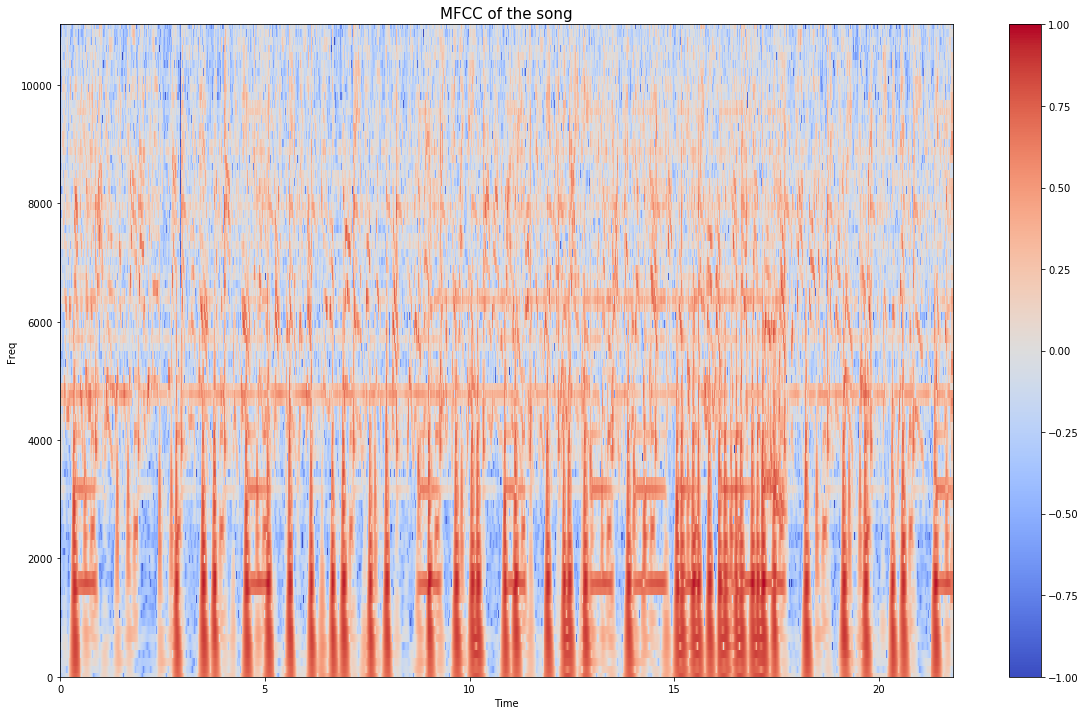

In [29]:
mfcc = librosa.core.cqt(y=y, 
                        sr=sr,
                        hop_length=704,
                        fmin=None, 
                        n_bins=84, 
                        bins_per_octave=12, 
                        tuning=0.0, 
                        filter_scale=1, 
                        norm=1, 
                        sparsity=0.01, 
                        window='hann', 
                        scale=True, 
                        pad_mode='reflect')
mfcc = librosa.amplitude_to_db(mfcc)

# normalization
# mfcc_norm = mfcc - mfcc.min()
# mfcc_norm /= mfcc.max()

# Cov_norm = np.cov(mfcc_norm)

print("Every sample will have a matrix of {}".format(mfcc.shape))

mfcc_norm = mfcc - mfcc.min()
mfcc_norm /= mfcc_norm.max()/2
mfcc_norm -= 1

print(mfcc_norm.min(), mfcc_norm.max())
plt.figure(figsize=(20, 12))
librosa.display.specshow(mfcc_norm, sr=sr, x_axis='time', y_axis='hz')
plt.ylabel("Freq")
plt.xlabel("Time")
plt.title("MFCC of the song", fontsize=15)
plt.colorbar()
plt.show()

In [4]:
def extract_cqt(input_path):
    y, sr = librosa.load(input_path, sr=None, mono = True)

    if sr != 22050:
        y = librosa.resample(y, sr, 22050)
        sr = 22050

    cqt = librosa.core.cqt(y=y, 
                            sr=sr,
                            hop_length=704)
    
    return librosa.power_to_db(cqt)

def process_audio_cqt():
    while True:
        input_path = q.get()
        if input_path is None:
            break
        
        filename = os.path.basename(input_path)[:-4]
        output_path = os.path.join("F:/Nicolas/DNUPycharmProjects/machine_learning/audio/FMA/preprocessed_audio", "cqt", filename+".npy")
        
        cqt = extract_cqt(input_path)
        
        cqt = cqt[:, :930]
        
        # normalization [-1, 1]
        cqt -= cqt.min()
        cqt /= cqt.max()/2
        cqt -= 1
                
        np.save(output_path, cqt)
        
        q.task_done()
        
q = queue.Queue()
num_worker_threads = 25

print("launch thread")
threads = []
for i in range(num_worker_threads):
    t = threading.Thread(target=process_audio_cqt)
    t.start()
    threads.append(t)
    
print("feeding queue")
for audio_path in glob.glob(os.path.join("F:/Nicolas/DNUPycharmProjects/machine_learning/audio/FMA/fma_small/*/*.mp3")):
    filename = os.path.basename(audio_path)[:-4]
    output_path = os.path.join("F:/Nicolas/DNUPycharmProjects/machine_learning/audio/FMA/preprocessed_audio", "cqt", filename+".npy")
    if not os.path.exists(output_path):
        q.put(audio_path)
q.join()

for i in range(num_worker_threads):
    q.put(None)

for t in threads:
    t.join()
print("end")

launch thread
feeding queue


C:\python36\envs\machine_learning\lib\site-packages\librosa\core\spectrum.py:863: UserWarning: power_to_db was called on complex input so phase information will be discarded. To suppress this warning, call power_to_db(magphase(D, power=2)[0]) instead.
  warnings.warn('power_to_db was called on complex input so phase '


end


In [35]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, Input, CuDNNLSTM, Concatenate, concatenate, Lambda
from keras.models import Model, load_model
from keras.callbacks import Callback, EarlyStopping
from keras.metrics import top_k_categorical_accuracy
from keras import backend as K

C:\python36\envs\machine_learning\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [36]:
label = pd.read_csv("F:/Nicolas/DNUPycharmProjects/machine_learning/audio/FMA/preprocessed_meta/classes.csv", index_col = 0)
label.head()

,genres,title
track_id,,
2,21,Hip-Hop
5,21,Hip-Hop
10,10,Pop
140,17,Folk
141,17,Folk


In [33]:
np.split(a[:, :630], 21, axis=1)[0].shape

(128, 30)

In [37]:
enc = LabelBinarizer()
y_enc = enc.fit_transform(label.title.values.reshape(-1, 1))
X = label.index.values

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y_enc, test_size=0.20, random_state=42)

In [56]:
NB_IMAGES_TRAIN = X_train.shape[0]
NB_IMAGES_TEST = X_test.shape[0]
N, T, I = X.shape[0], 930, 84
NB_CLASSES = 8
BATCH_SIZE = 50
EPOCHS  = 150

def batch_generator(idx_audio_list, classe, batch_size = 64):
    batch_features = np.zeros((batch_size, T, I))
    batch_labels = np.zeros((batch_size, 8))
    while True:
        index = np.random.choice(len(idx_audio_list), 1)
        idx_audio = idx_audio_list[index]
        for i in range(batch_size):
            file_path = os.path.join("F:/Nicolas/DNUPycharmProjects/machine_learning/audio/FMA/preprocessed_audio", "cqt_norm", "{0:06d}".format(idx_audio[0]) + ".npy")
            m = np.swapaxes(np.load(file_path),0,1)
            batch_features[i] = (m+1)/2
            batch_labels[i] = classe[index]
        yield np.split(batch_features, 30, axis=1), batch_labels
        
train_generator = batch_generator(X_train, y_train, BATCH_SIZE)
test_generator = batch_generator(X_test, y_test, BATCH_SIZE)

In [61]:
# K.clear_session()

# input_layer = [Input(shape=(30, 84)) for n in range(30)]
# first_layer = [CuDNNLSTM(units=128, return_sequences=False)(i) for i in input_layer]

# f = Lambda(lambda tensors: K.stack(tensors, axis=1))(first_layer)

# o1 = CuDNNLSTM(units=128, return_sequences=False) (f)

# outputs = Dense(16, activation='softmax') (o1)

# model = Model(inputs=input_layer, outputs=outputs)

# model.summary()

In [57]:
K.clear_session()

shared_cell = CuDNNLSTM(units=128, return_sequences=False)

input_layer = [Input(shape=(31, 84)) for n in range(30)]
first_layer = [shared_cell(i) for i in input_layer]

f = Lambda(lambda tensors: K.stack(tensors, axis=1))(first_layer)

o1 = CuDNNLSTM(units=128, return_sequences=False) (f)

d1 = Dense(64, activation='relu') (o1)

outputs = Dense(8, activation='softmax') (d1)

model = Model(inputs=input_layer, outputs=outputs)

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 31, 84)       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 31, 84)       0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 31, 84)       0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 31, 84)       0                                            
__________________________________________________________________________________________________
input_5 (I

In [60]:
model.compile(optimizer='Nadam', loss='categorical_crossentropy', 
              metrics = ["categorical_crossentropy", "accuracy"])

In [61]:
model.fit_generator(generator = train_generator,
                    steps_per_epoch = NB_IMAGES_TRAIN//BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=test_generator,
                    validation_steps = NB_IMAGES_TEST//BATCH_SIZE,
                    verbose=1
                    )

Epoch 1/150
127/127 [==============================] - 10s 77ms/step - loss: 2.0856 - categorical_crossentropy: 2.0856 - acc: 0.0690 - val_loss: 2.0791 - val_categorical_crossentropy: 2.0791 - val_acc: 0.1065
Epoch 2/150
127/127 [==============================] - 8s 59ms/step - loss: 2.0779 - categorical_crossentropy: 2.0779 - acc: 0.1743 - val_loss: 2.0797 - val_categorical_crossentropy: 2.0797 - val_acc: 0.1026
Epoch 3/150
127/127 [==============================] - 7s 59ms/step - loss: 2.0797 - categorical_crossentropy: 2.0797 - acc: 0.0746 - val_loss: 2.0824 - val_categorical_crossentropy: 2.0824 - val_acc: 0.1639
Epoch 4/150
127/127 [==============================] - 8s 61ms/step - loss: 2.0839 - categorical_crossentropy: 2.0839 - acc: 0.1039 - val_loss: 2.0854 - val_categorical_crossentropy: 2.0854 - val_acc: 0.0329
Epoch 5/150
127/127 [==============================] - 8s 61ms/step - loss: 2.0795 - categorical_crossentropy: 2.0795 - acc: 0.1219 - val_loss: 2.0661 - val_categorica

127/127 [==============================] - 8s 60ms/step - loss: 2.0802 - categorical_crossentropy: 2.0802 - acc: 0.1024 - val_loss: 2.0902 - val_categorical_crossentropy: 2.0902 - val_acc: 0.1310
Epoch 80/150
127/127 [==============================] - 8s 59ms/step - loss: 2.0861 - categorical_crossentropy: 2.0861 - acc: 0.1274 - val_loss: 2.1066 - val_categorical_crossentropy: 2.1066 - val_acc: 0.0348
Epoch 81/150
127/127 [==============================] - 8s 60ms/step - loss: 2.0828 - categorical_crossentropy: 2.0828 - acc: 0.1301 - val_loss: 2.0768 - val_categorical_crossentropy: 2.0768 - val_acc: 0.1406
Epoch 82/150
127/127 [==============================] - 8s 59ms/step - loss: 2.0738 - categorical_crossentropy: 2.0738 - acc: 0.1676 - val_loss: 2.0675 - val_categorical_crossentropy: 2.0675 - val_acc: 0.2226
Epoch 83/150
127/127 [==============================] - 8s 59ms/step - loss: 2.0826 - categorical_crossentropy: 2.0826 - acc: 0.1198 - val_loss: 2.0906 - val_categorical_crossen

MemoryError: 

In [82]:
tx, cx = next(test_generator)
y_pred = model.predict(tx)

In [83]:
y_pred

array([[0.1247811 , 0.13152026, 0.12188392, 0.1262216 , 0.12081309,
        0.11787324, 0.12960963, 0.1272971 ],
       [0.1247811 , 0.13152026, 0.12188392, 0.1262216 , 0.12081309,
        0.11787324, 0.12960963, 0.1272971 ],
       [0.1247811 , 0.13152026, 0.12188392, 0.1262216 , 0.12081309,
        0.11787324, 0.12960963, 0.1272971 ],
       [0.1247811 , 0.13152026, 0.12188392, 0.1262216 , 0.12081309,
        0.11787324, 0.12960963, 0.1272971 ],
       [0.1247811 , 0.13152026, 0.12188392, 0.1262216 , 0.12081309,
        0.11787324, 0.12960963, 0.1272971 ],
       [0.1247811 , 0.13152026, 0.12188392, 0.1262216 , 0.12081309,
        0.11787324, 0.12960963, 0.1272971 ],
       [0.1247811 , 0.13152026, 0.12188392, 0.1262216 , 0.12081309,
        0.11787324, 0.12960963, 0.1272971 ],
       [0.1247811 , 0.13152026, 0.12188392, 0.1262216 , 0.12081309,
        0.11787324, 0.12960963, 0.1272971 ],
       [0.1247811 , 0.13152026, 0.12188392, 0.1262216 , 0.12081309,
        0.11787324, 0.129609

In [78]:
cx

array([[0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 